# Elevation DFD

Logan Gall, gall0487

Attributions/Assistance:
Laure Briol,
Gregory Kohler,
ESRI Arcpy documentation,
ChatGPT,
LucidChart

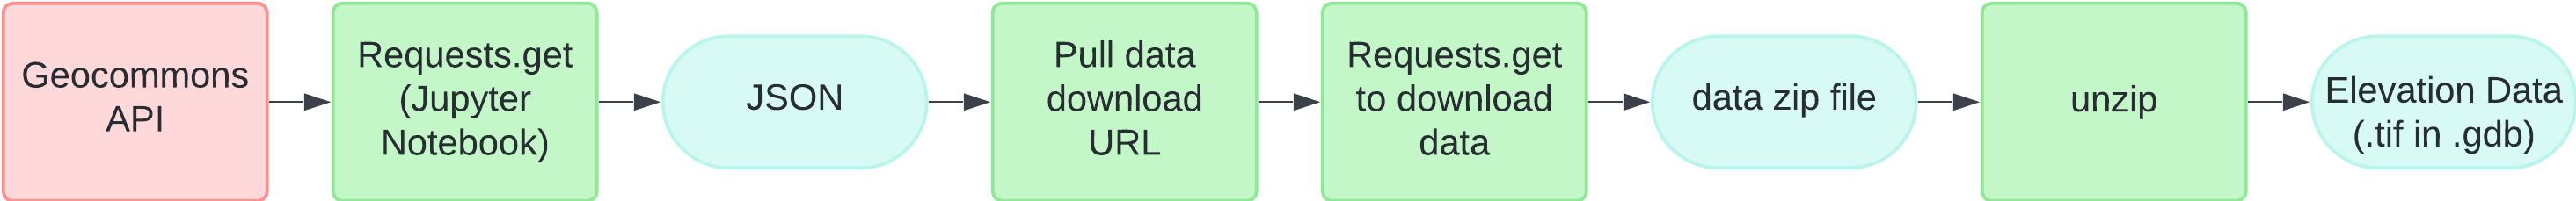

In [1]:
#Fixing error in arcgis notebooks, wrong locale wouldn't let us import pandas
import os
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'

#Fixing error in arcgis notebooks, wrong locale wouldn't let us import pandas
import locale
locale.setlocale(locale.LC_ALL, '')

import requests
import zipfile
import shutil
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import arcpy

In [2]:
def fetch_and_extract_data(json_url, resource_index, folder_name, zip_name):
    """
    Fetches data from a specified API URL, downloads, and extracts the ZIP file.
    """
    # Perform the GET request to fetch the JSON data from the API
    response = requests.get(json_url)
    if response.status_code == 200:
        #pull json data
        json_data = response.json()
        #Extract download link from resources tab
        data_url = json_data['result']['resources'][resource_index]['url']
        print(f"Target URL: {data_url}")
        
        # Proceed to download and extract the ZIP file
        current_directory = os.getcwd()
        zip_path = os.path.join(current_directory, zip_name)
        folder_path = os.path.join(current_directory, folder_name)
        
        if not os.path.exists(folder_path):
            os.mkdir(folder_path)
        
        #Download data using url given from API
        with requests.get(data_url, stream=True) as response:
            with open(zip_path, 'wb') as file:
                shutil.copyfileobj(response.raw, file)
        
        #Extract downloaded zip
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        
        return folder_path
    else:
        print(f"Failed to fetch JSON data. Status code: {response.status_code}")
        return None

#location to current directory
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(file_path)
#absolute Path for geodatabase
file_path_db = file_path + '\MN_Geo_Data\elev_30m_digital_elevation_model.gdb'
arcpy.env.workspace = file_path_db

# Process for MN_Geo_Data
mn_geo_folder = fetch_and_extract_data('https://gisdata.mn.gov/api/3/action/package_show?id=elev-30m-digital-elevation-model', 1, "MN_Geo_Data", "MN_data.zip")
if mn_geo_folder:
    aprx = arcpy.mp.ArcGISProject("CURRENT")
    map_obj = aprx.activeMap
    map_obj.addDataFromPath(os.path.join(mn_geo_folder, r'Digital Elevation Model - 30m Resolution.lyr'))

# Process for MN_Shape_Data
mn_shape_folder = fetch_and_extract_data('https://gisdata.mn.gov/api/3/action/package_show?id=bdry-state-of-minnesota', 1, "MN_Shape_Data", "MN_shape_data.zip")
if mn_shape_folder:
    aprx = arcpy.mp.ArcGISProject("CURRENT")
    map_obj = aprx.activeMap
    map_obj.addDataFromPath(os.path.join(mn_shape_folder, r'Minnesota State Boundary.lyr'))

Target URL: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/elev_30m_digital_elevation_model/fgdb_elev_30m_digital_elevation_model.zip
Target URL: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/bdry_state_of_minnesota/fgdb_bdry_state_of_minnesota.zip


## QAQC

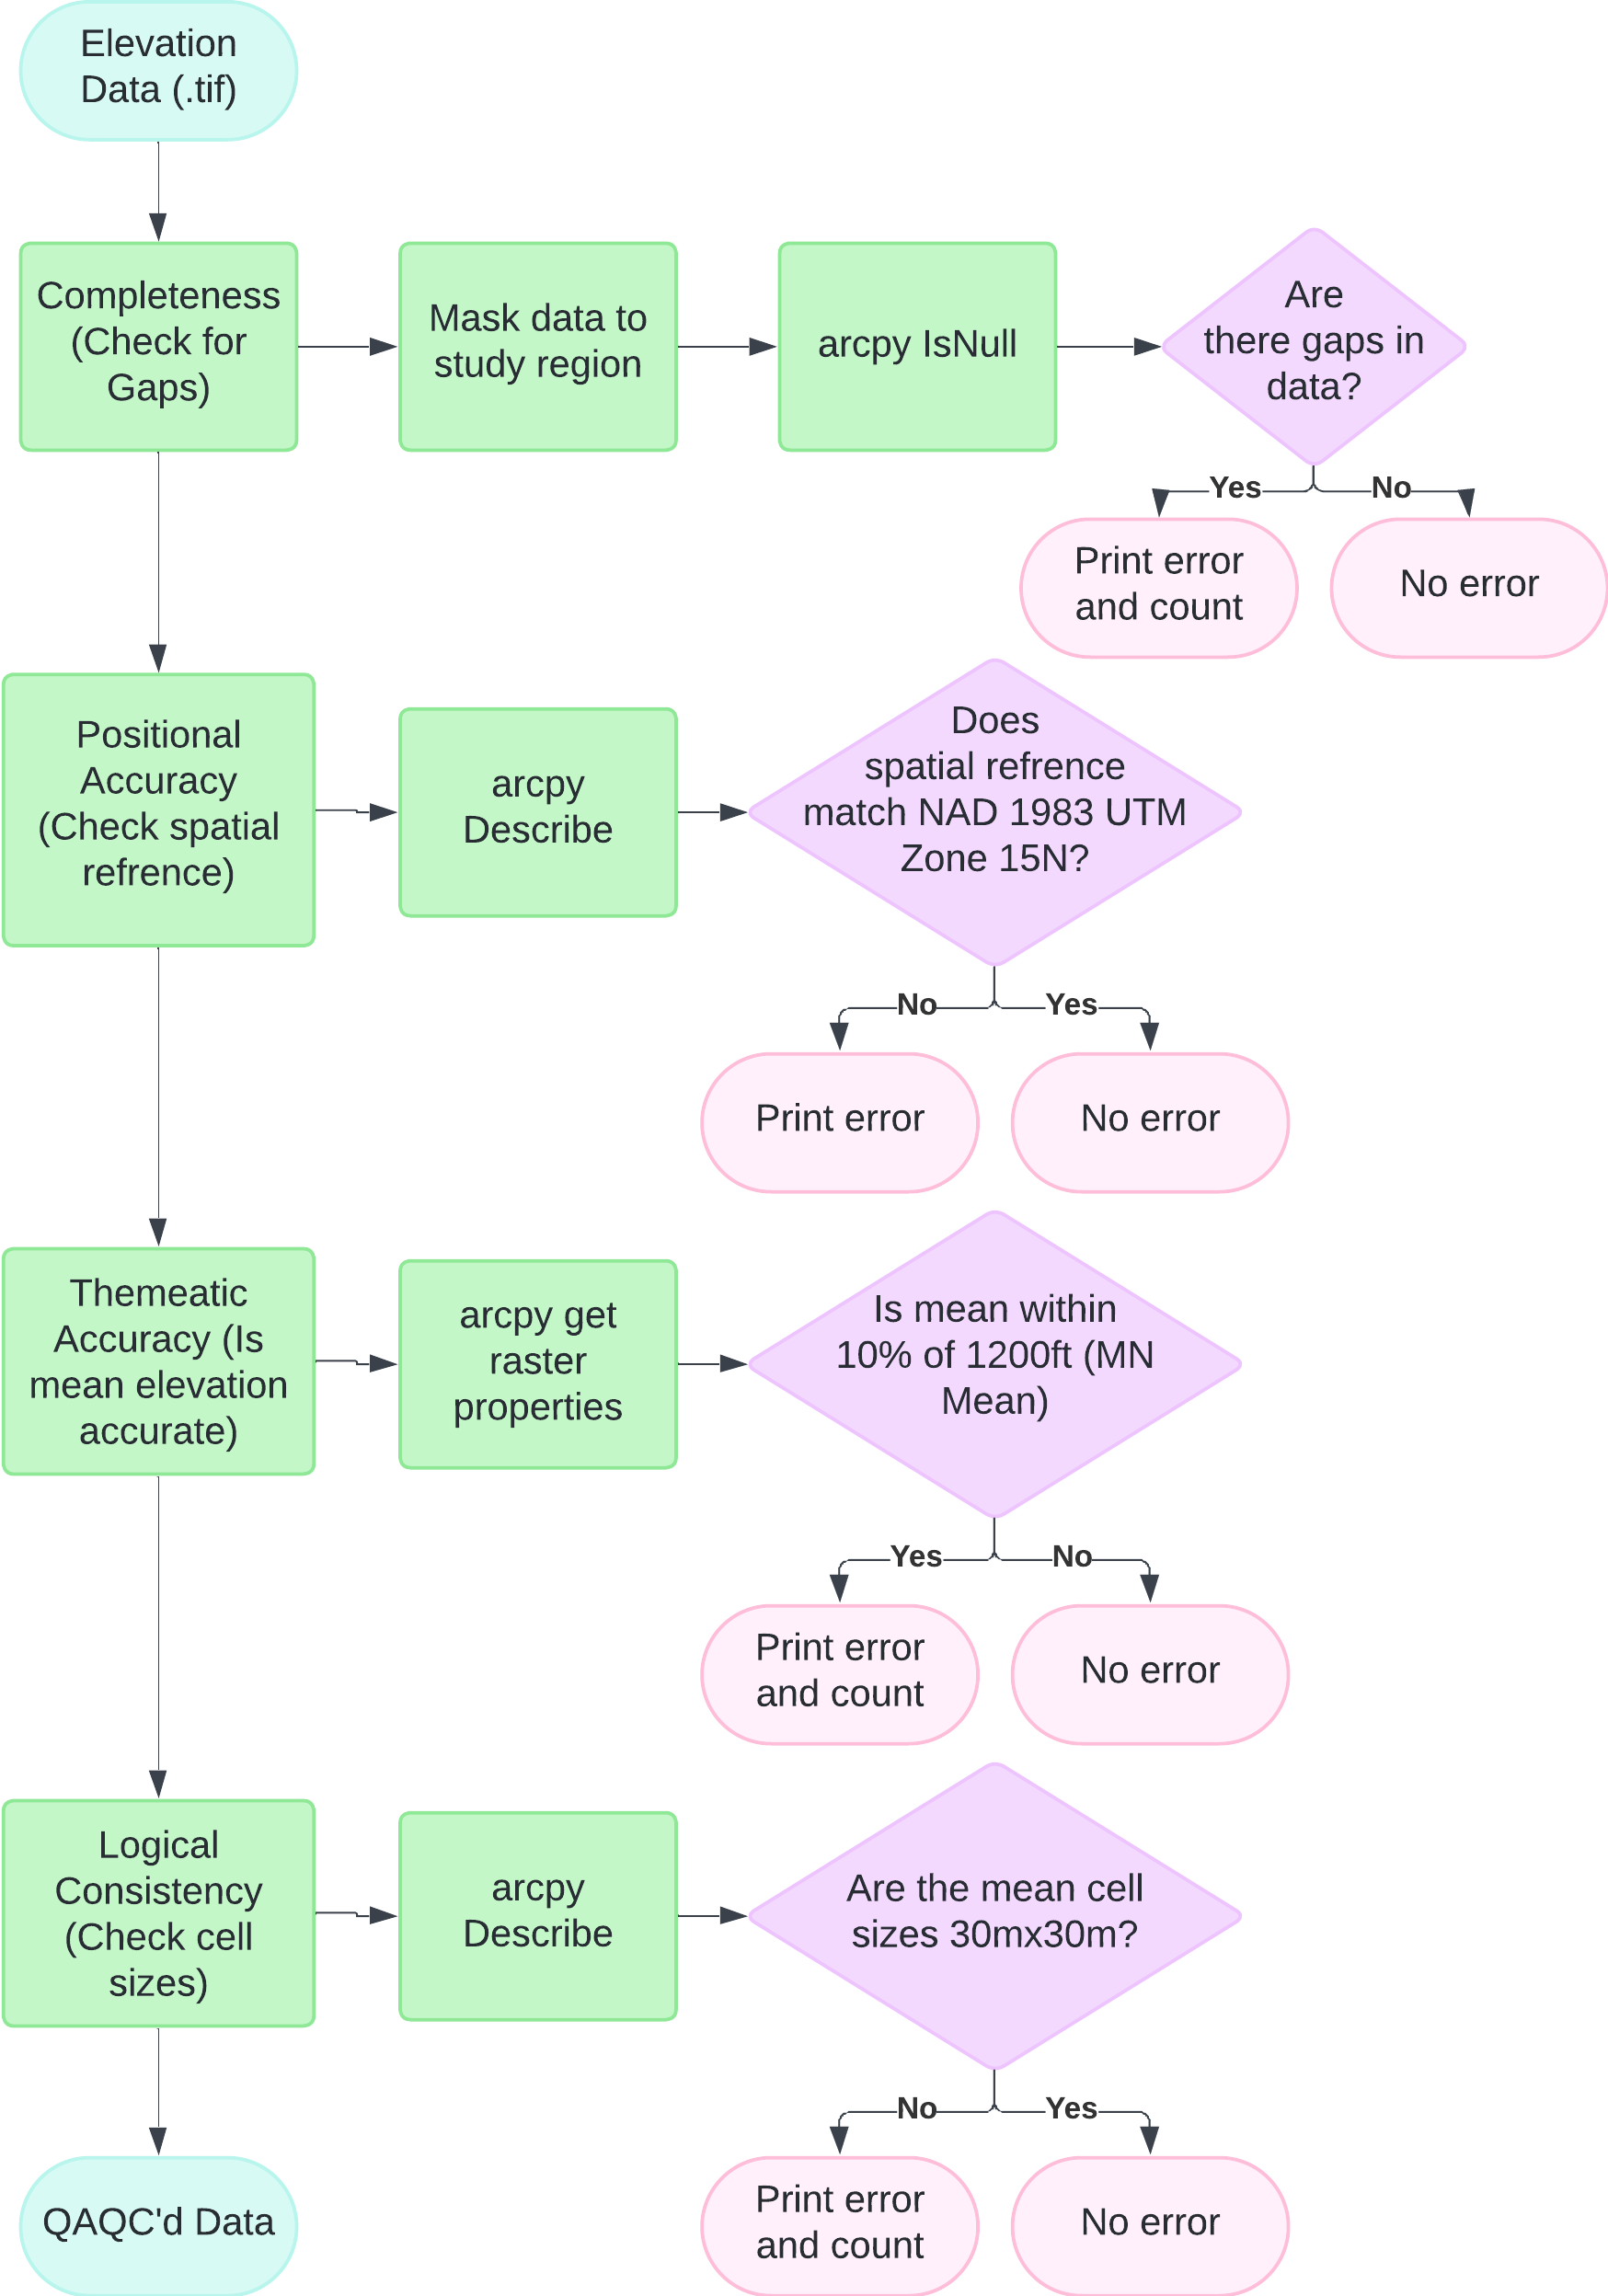

In [4]:
# Define paths for the Minnesota boundary and the raster dataset
mn_boundary_filepath = r"../../MN_Shape_Data/bdry_state_of_minnesota.gdb/state_of_minnesota"
elevation_raster_path = "digital_elevation_model_30m"

# Rasterizing the Minnesota boundary to use as a mask
mn_rasterized_mask = "mn_raster_mask"

# Convert Minnesota boundary polygon to raster
arcpy.conversion.PolygonToRaster(
    in_features=mn_boundary_filepath,
    value_field="OBJECTID",
    out_rasterdataset=mn_rasterized_mask,
    cell_assignment="MAXIMUM_AREA",
    priority_field="NONE",
    cellsize=elevation_raster_path,
    build_rat="BUILD"
)

# Setting NoData value for areas outside Minnesota
mn_raster_mask_with_nodata = arcpy.ia.SetNull(mn_rasterized_mask, 1, "VALUE <> 1")

# Applying the prepared mask to the elevation dataset
masked_elevation_raster_name = "masked_elevation_raster"
arcpy.env.mask = mn_raster_mask_with_nodata

# Creating a copy of the elevation dataset with the mask applied
arcpy.CopyRaster_management(elevation_raster_path, masked_elevation_raster_name)

# Analyzing for gaps within the elevation data
elevation_data_gaps = arcpy.sa.IsNull(masked_elevation_raster_name)

# Counting gaps in the elevation data
number_of_gaps = arcpy.GetCount_management(elevation_data_gaps)

# Evaluating and reporting on data completeness
gap_count_output = int(number_of_gaps.getOutput(0))
if gap_count_output > 0:
    print(f"{gap_count_output} gaps found in elevation data.")
    print("Elevation data contains gaps.")
else:
    print("Elevation data is complete.")

2 gaps found in elevation data.
Elevation data contains gaps.


In [5]:
tif_path = "digital_elevation_model_30m"
expected_ref="NAD_1983_UTM_Zone_15N"

# Obtain spatial reference details of the TIFF file
spatial_reference = arcpy.Describe(tif_path).spatialReference

# Evaluate and print the result based on the spatial reference check
if spatial_reference.name == expected_ref:
    print(f"Spatial Reference Check: Passed. ({spatial_reference.name})")
else:
    print(f"Spatial Reference Check: Failed. Found: {spatial_reference.name}, Expected: {expected_ref}")

Spatial Reference Check: Passed. (NAD_1983_UTM_Zone_15N)


In [3]:
# Define raster dataset name
dataset_name = 'digital_elevation_model_30m'

# Initialize raster object from dataset
raster_obj = arcpy.Raster(dataset_name)

# Calculate mean elevation from raster properties
mean_elev_value = float(arcpy.GetRasterProperties_management(raster_obj, 'MEAN').getOutput(0))

# Display the mean elevation
print(f"Mean elevation of the raster dataset: {mean_elev_value}")

# Set elevation thresholds
min_acceptable = 1080
max_acceptable = 1320

# Validate mean elevation against acceptable range 
if min_acceptable <= mean_elev_value <= max_acceptable:
    print("Data is within expected elevation")
else:
    print("Data is outside expected elevation")

Mean elevation of the raster dataset: 1217.65105684861
Data is within expected elevation


In [6]:
raster_path = "digital_elevation_model_30m"

# Access raster properties
raster_properties = arcpy.Describe(raster_path)
expected_val = 30.0

# Extract cell dimensions
width = raster_properties.meanCellWidth
height = raster_properties.meanCellHeight

# Format and print cell size information
print(f"Raster Cell Size - Width: {width} meters, Height: {height} meters")

# Validate cell dimensions
if width == expected_val and height == expected_val:
    print("Raster cell size is as expected.")
else:
    print("Mismatch in raster cell size.")

Raster Cell Size - Width: 30.0 meters, Height: 30.0 meters
Raster cell size is as expected.
